# Case 2. Diabetic Retinopathy Analysis
Sanni Tolonen<br>
26.2.2018<br>
Cognitive Systems for Health Technology Applications, Spring 2018<br>
Helsinki Metropolia University of Applied Sciences

<h2>1. Objectives</h2><br>
The aim of this assignment is to learn to use convolutional neural networks to classify medical
images.

<h2> 2. Required libraries </h2>

In [1]:
# import libraries and functions

import numpy as np
import matplotlib.pyplot as plt 
import pickle
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import time

Using TensorFlow backend.


Numpy is used for scientific computing and creating multidimensional arrays, matplotlib for ploting figures, pickle for saving the history of the model, keras for building the convolutional neural network and time for calculating time.

<h2> 3. Data description and preprocessing </h2>

This dataset is a large set of high-resolution retina images taken under a variety of imaging conditions. 
A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4:

<ul>
<li>0 - No DR</li>
<li>1 - Mild</li>
<li>2 - Moderate</li>
<li>3 - Severe</li>
<li>4 - Proliferative DR</li>
</ul>

The images come from different models and types of cameras, which can affect the visual appearance. Some images are shown as one would see the retina anatomically meaning macula on the left, optic nerve on the right for the right eye. Others are shown as one would see through a microscope condensing lens in example inverted, as one sees in a typical live eye exam. There are two ways to tell if an image is inverted:

It is inverted if the macula, the small dark central area, is slightly higher than the midline through the optic nerve. If the macula is lower than the midline of the optic nerve, it's not inverted.
If there is a notch on the side of the image (square, triangle, or circle) then it's not inverted. If there is no notch, it's inverted.

In [2]:
# dataset directories and labels files

train_dir = "../dataset2/train" 
validation_dir = "../dataset2/validation" 
test_dir = "../dataset2/test" 

#preprocessing function

def my_fun(x):
    r = x[:, :, 0]
    g = x[:, :, 1]
    b = x[:, :, 2]
    r = (r - np.mean(r))/(12.0*np.std(r))
    g = (g - np.mean(g))/(12.0*np.std(g))
    b = (b - np.mean(g))/(12.0*np.std(b))
    x[:, :, 0] = r
    x[:, :, 1] = g
    x[:, :, 2] = b
    x += 0.5
    return x

Dataset is splitted to train, validation and test sets. For preprocessing I used a function defined by Sakari Lukkarinen. 

<h2> 4. Modeling and compilation </h2>

In [3]:
# training parameters

batch_size = 40
epochs = 40
steps_per_epoch = 48 
validation_steps = 13
image_height = 150
image_width = 200 

# create datagenerators

train_datagen = ImageDataGenerator(preprocessing_function = my_fun)
validation_datagen = ImageDataGenerator(preprocessing_function = my_fun)
test_datagen = ImageDataGenerator(preprocessing_function = my_fun)

# generator for train dataset

print('Training dataset.')
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

# generator for validation dataset

print('Validation dataset.')
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

# generator for test dataset

print('Test dataset.')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')


Training dataset.
Found 1928 images belonging to 2 classes.
Validation dataset.
Found 1021 images belonging to 2 classes.
Test dataset.
Found 1013 images belonging to 2 classes.


<h2> 5. Training and validation </h2>

This model is designed with a Conv2D layer followed by MaxPool2D layer. After five sets of these, there is one MaxPool2D layer and a Flatten layer to flatten the input. In the end there is a Dropout layer for weight regularization to avoid overfitting and a Dense layer, two sets of these.

In [5]:
# build the model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(image_height, image_width, 3)))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# compile the model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])


# train the model

t1 = time.time()
h = model.fit_generator(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      verbose = 1,
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps)
t2 = time.time()

# store the elapsed time into history

h.history.update({'time_elapsed': t2 - t1})
print(' ')
print('Total elapsed time for training: {:.3f} minutes'.format((t2-t1)/60))
print(' ')

# save the model and history

model.save('case_2_run_2.h5')
pickle.dump(h.history, open('case_2_history_2.p', 'wb'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 198, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 99, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 48, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 23, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 21, 256)       295168    
__________

In [12]:
print('Time per epoch {:.2f} hours.'.format((t2-t1)/3600))
print('Time per epoch {:.2f} minutes.'.format((t2-t1)/40/60))

Time per epoch 6.00 hours.
Time per epoch 8.99 minutes.


<h2> 6. Evaluation </h2>

Here the model created above is tested with the testing set. 

In [7]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

r = model.evaluate_generator(test_generator, steps = 21)

# loss and accuracy
r

Found 1013 images belonging to 2 classes.


[4.7778640928722567, 0.70357142459778554]

<h2> 7. Results and discussion </h2>

Training accuracy is just above 0.70 almost the whole time. The final testing accuracy is 0.70. In the end of training the loss function is 4.7 which is really big. This means that the inconsistency between predicted value and actual label is large. The final testing loss function is 4.78. 

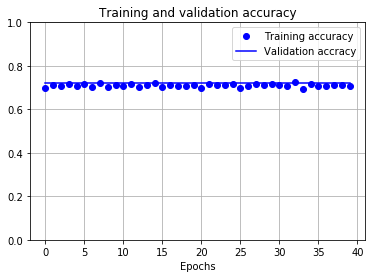

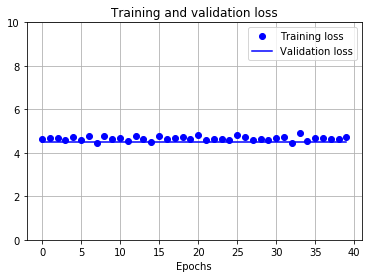

In [10]:
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accracy')
plt.title('Training and validation accuracy')
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0, 10])
plt.xlabel('Epochs')
plt.grid()
plt.legend()  

plt.show()

In [9]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

r = model.evaluate_generator(test_generator, steps = 21)

# loss and accuracy
r

Found 1013 images belonging to 2 classes.


[4.7778641269320534, 0.70357142459778554]

<h2>8. Conclusions</h2>

This Case 2 was a nice and interesting introduction to the convolutional neural networks. I think the difficulty level was ok, could have maybe been a little easier for my taste. I underestimated the time consuming of this assignment.

70% accuracy isn't that good for binary classification and it's not good enough for a medical classifier. I made quite a few versions and took probably too much time with them, some of the trainings lasted for 14 hours. I don't understand what went wrong with the training because validation accuracy and validation loss stays the same all the time with all combinations that I tried so there is definately some more learning to do for me. 